I have created this dataset image that composed by mobile phones camera that produces from a 12 MP, f/2.4, 52mm (telephoto), 1/3.6", 1.0µm, PDAF, OIS.  Running experiments with mediapipe how it reacts with pixel bightness with the fraction of light.  

In [22]:
! pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
from google.colab import files
uploaded = files.upload()

Saving 01.jpg to 01.jpg


The images is uploaded from files and use Mediapipe to run the model on them. Shown that this image will be finding out if the hand is detected with the use of this library created at certain angles, light, resolution settings which may give different data noise making it difficult to predict

01.jpg


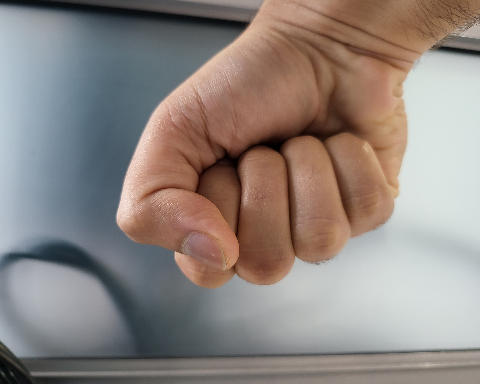

In [24]:
import cv2
from google.colab.patches import cv2_imshow
import math
import numpy as np

DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480
def resize_and_show(image):
  h, w = image.shape[:2]
  if h < w:
    img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
  else:
    img = cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
  cv2_imshow(img)

# Read images with OpenCV.
images = {name: cv2.imread(name) for name in uploaded.keys()}
# Preview the images.
for name, image in images.items():
  print(name)   
  resize_and_show(image)

Handedness of 01.jpg:
[classification {
  index: 1
  score: 0.9954901933670044
  label: "Right"
}
]
Hand landmarks of 01.jpg:
Index finger tip coordinate: ( 1180.6285724043846, 835.8670693337917)


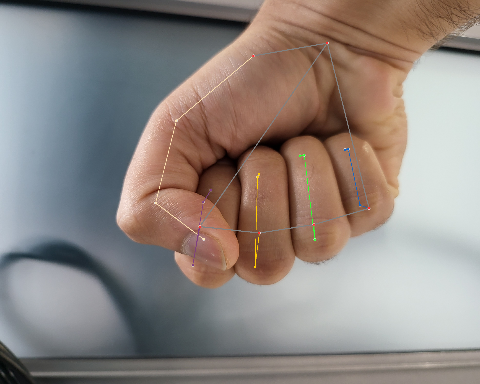

In [26]:
# Run MediaPipe Hands.
with mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=2,
    min_detection_confidence=0.7) as hands:
  for name, image in images.items():
    # Convert the BGR image to RGB, flip the image around y-axis for correct 
    # handedness output and process it with MediaPipe Hands.
    results = hands.process(cv2.flip(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 1))

    # Print handedness (left v.s. right hand).
    print(f'Handedness of {name}:')
    print(results.multi_handedness)

    if not results.multi_hand_landmarks:
      continue
    # Draw hand landmarks of each hand.
    print(f'Hand landmarks of {name}:')
    image_hight, image_width, _ = image.shape
    annotated_image = cv2.flip(image.copy(), 1)
    for hand_landmarks in results.multi_hand_landmarks:
      # Print index finger tip coordinates.
      print(
          f'Index finger tip coordinate: (',
          f'{hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].x * image_width}, '
          f'{hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].y * image_hight})'
      )
      mp_drawing.draw_landmarks(
          annotated_image,
          hand_landmarks,
          mp_hands.HAND_CONNECTIONS,
          mp_drawing_styles.get_default_hand_landmarks_style(),
          mp_drawing_styles.get_default_hand_connections_style())
    resize_and_show(cv2.flip(annotated_image, 1))

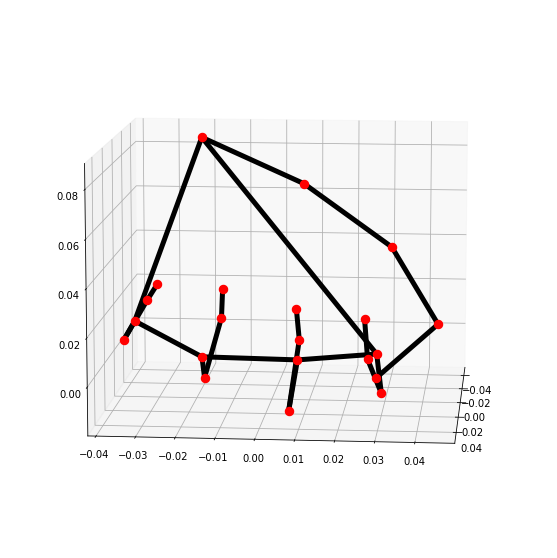

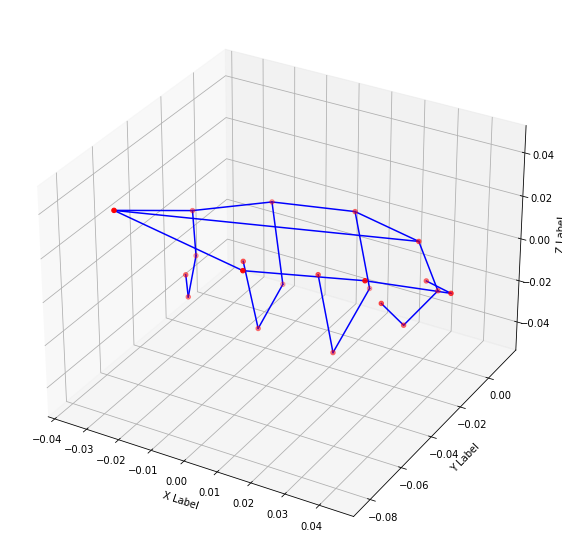

In [27]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
def plot_3d_landmarks(landmarks, connections):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    xs, ys, zs = [], [], []
    for landmark in landmarks.landmark:
        xs.append(landmark.x)
        ys.append(landmark.y)
        zs.append(landmark.z)

    ax.scatter(xs, ys, zs, c='r', marker='o')
    for connection in connections:
        start_idx, end_idx = connection
        ax.plot([xs[start_idx], xs[end_idx]], [ys[start_idx], ys[end_idx]], [zs[start_idx], zs[end_idx]], 'b')
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.show()

for hand_world_landmarks in results.multi_hand_world_landmarks:
    mp_drawing.plot_landmarks(
        hand_world_landmarks, mp_hands.HAND_CONNECTIONS, azimuth=5)
for hand_world_landmarks in results.multi_hand_world_landmarks:
    plot_3d_landmarks(hand_world_landmarks, mp_hands.HAND_CONNECTIONS)


In [28]:
def angle_between_vectors(v1, v2):
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    cosine_angle = dot_product / (norm_v1 * norm_v2)
    return np.degrees(np.arccos(np.clip(cosine_angle, -1.0, 1.0)))


In [29]:
def calculate_angles(hand_landmarks):
    landmark_coords = [(landmark.x, landmark.y, landmark.z) for landmark in hand_landmarks.landmark]
    landmark_coords = np.array(landmark_coords)

    thumb_base = landmark_coords[mp_hands.HandLandmark.THUMB_CMC]
    index_base = landmark_coords[mp_hands.HandLandmark.INDEX_FINGER_MCP]
    middle_base = landmark_coords[mp_hands.HandLandmark.MIDDLE_FINGER_MCP]
    ring_base = landmark_coords[mp_hands.HandLandmark.RING_FINGER_MCP]
    pinky_base = landmark_coords[mp_hands.HandLandmark.PINKY_MCP]
    
    v_thumb_index = thumb_base - index_base
    v_index_middle = index_base - middle_base
    v_middle_ring = middle_base - ring_base
    v_ring_pinky = ring_base - pinky_base
    
    angle_thumb_index = angle_between_vectors(v_thumb_index, v_index_middle)
    angle_index_middle = angle_between_vectors(v_index_middle, v_middle_ring)
    angle_middle_ring = angle_between_vectors(v_middle_ring, v_ring_pinky)
    
    angles = {
        "Thumb-Index": angle_thumb_index,
        "Index-Middle": angle_index_middle,
        "Middle-Ring": angle_middle_ring,
    }
    
    return angles


In [30]:
angles = calculate_angles(hand_landmarks)
print("Angles between fingers:")
for finger_pair, angle in angles.items():
    print(f"{finger_pair}: {angle:.2f} degrees")


Angles between fingers:
Thumb-Index: 96.18 degrees
Index-Middle: 21.84 degrees
Middle-Ring: 9.89 degrees


Ref: Lugaresi, C., Tang, J., Nash, H., McClanahan, C., Uboweja, E., Hays, M., Zhang, F., Chang, C.L., Yong, M., Lee, J. and Chang, W.T., 2019, June. Mediapipe: A framework for perceiving and processing reality. In Third Workshop on Computer Vision for AR/VR at IEEE Computer Vision and Pattern Recognition (CVPR) (Vol. 2019).